<a href="https://colab.research.google.com/github/DarshanDinni/learn_pytorch/blob/main/01_Pytorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# Importing the data

import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# Creating the data using the below formula
# Y = mX + c - linear regression formula

weight = 0.5
bias = 0.7

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

print("Tensor X: \n", X[:5])
print("Tensor y: \n", y[:5])

Tensor X: 
 tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
Tensor y: 
 tensor([[0.7000],
        [0.7100],
        [0.7200],
        [0.7300],
        [0.7400]])


In [49]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [50]:
# Spliting the data into train and test set

X_train, y_train = X[:40], y[:40]
X_test, y_test = X[40:], y[40:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

In [51]:
# Visualize the data

def plot_graph(axis, training_data=X_train, testing_data=X_test, training_label=y_train, testing_label=y_test, prediction=None):
  # Setting the size of the graph
  plt.figure(figsize=(10, 7))

  # Plotting training data
  axis.scatter(X_train, y_train, c='b',s=4, label='Training data points')

  # Plotting testing data
  axis.scatter(X_test, y_test, c='r',s=4, label='Testing data points')

  # Plotting prediction data
  if prediction != None:
    axis.scatter(testing_data, prediction, c='g', s=4, label='Prediction data points')

  axis.legend()

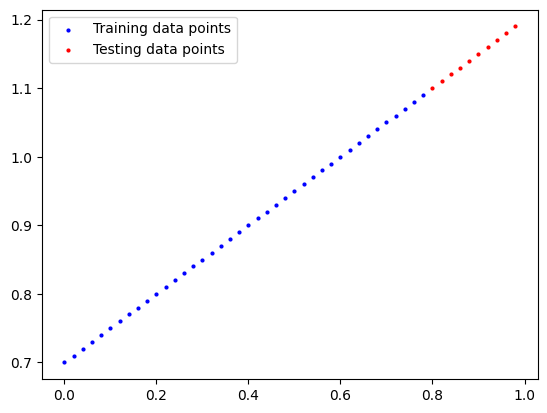

<Figure size 1000x700 with 0 Axes>

In [52]:
figure, axis = plt.subplots(1, 1)
plot_graph(axis=axis)
plt.show()

In [53]:
# Build model

# Creating linear regression model which inherits nn.Module which has all the neural network modules to work with
class LinearRegressionModel(nn.Module):

  # Defining the constructor
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, dtype=float))
    self.bias = nn.Parameter(torch.randn(1, dtype=float))

  # As we are inheriting the nn.Module we need to overwrite the forward function
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias

In [54]:
# Creating a seed value
torch.manual_seed(42)

# Creating the instance of the linear regression model
model_0 = LinearRegressionModel()

In [55]:
# Checking the parameters set for our model
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [56]:
# So our goal is to let the model learn so that it can better fit the data by finding the correct values for weight and bias
# The correct values of weight and bias are as below
weight, bias

(0.5, 0.7)

In [57]:
# Code run under this inference mode gets better performance by disabling view tracking and version counter bumps
with torch.inference_mode():
  # Making the prediction with testing data points
  y_prediction = model_0(X_test)

y_prediction

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], dtype=torch.float64)

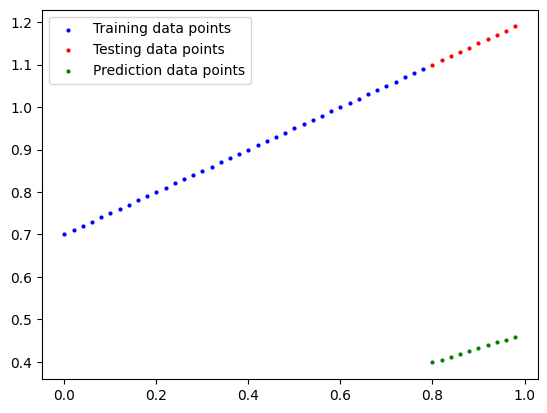

<Figure size 1000x700 with 0 Axes>

In [58]:
# Plotting the prediction data points to check the how model is performing
figure, axis = plt.subplots(1, 1)
plot_graph(axis=axis, prediction=y_prediction)

As from the above graph that its obvious that the model's prediction of bad so we need to train the model so that it can learn how to predict the values as close as possible

So to train the model we need to create optimizer and loss function

**Loss function:** A loss function is a mathematical function that quantifies the difference between predicted and actual values in a machine learning model. It measures the model's performance and guides the optimization process by providing feedback on how well it fits the data

**Optimizer:** An optimizer object that will hold the current state and will update the parameters based on the computed gradients.

In [59]:
# Optimizer - I will be using SGD because Stochastic Gradient Descent (SGD) is a variant of the Gradient Descent algorithm that is used for optimizing machine learning models.
# It addresses the computational inefficiency of traditional Gradient Descent methods when dealing with large datasets in machine learning projects.
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

# Loss function - we are using L1loss because it suits the problem we are deal to solve ie, that measures the mean absolute error (MAE) between each element in the input x and target y.
loss_function = nn.L1Loss()

##**Training the model**

In [60]:
# Setting how many time we want to iterate the loop to train the model so it learns, this value can be changed based on how model learns.
epochs = 200

epoch_value = []
training_loss = []
testing_loss = []

print(f'Actual values that we wan the model to achieve weight: {weight} and bias: {bias}')
print(f'Values of parameter before the training process: {model_0.state_dict()}\n')

for epoch in range(epochs):

  # Step 1: We write this to tells the model that we are training the model. This helps inform layers which are designed to behave differently during training and evaluation phase
  model_0.train()

  # Step 2: Put the training data points through the forward pass function to predict the label values so that we can train the model
  y_pred = model_0(X_train)

  # Step 3: We use the above defined loss function
  loss = loss_function(y_pred, y_train)

  # Step 4:
  '''
  Once you've completed a step, you don't really need to keep track of your previous suggestion (i.e. gradients) of where to step.
  By zeroing the gradients, you are throwing away this information. With the next batch of inputs, you begin from a clean slate to suggest where to step next.
  This suggestion is pure and not influenced by the past. You then feed this "pure" information to the optimizer, which then decides exactly where to step.
  Of course, you can decide to hold onto previous gradients, but that information is somewhat outdated since you're in an entirely new spot on the loss surface.
  Who is to say that the best direction to go next is still the same as the previous? It might be completely different!
  That's why most popular optimization algorithms throw most of that outdated information away (by zeroing the gradients).
  '''
  optimizer.zero_grad()

  # Step 5:  All this does is compute gradient of loss w.r.t all the parameters in loss that have requires_grad = True and store them in parameter
  loss.backward()

  # Step 6:  Performs a parameter update based on the current gradient (stored in . grad attribute of a parameter) and the update rule
  optimizer.step()

  # Testing
  model_0.eval()

  # We are using inference_mode so that code can better perform by disabling view tracking and version counter bumps
  with torch.inference_mode():
    y_pred_test = model_0(X_test)
    test_loss = loss_function(y_pred_test, y_test)

  if epoch % 10 == 0:
    epoch_value.append(epoch)
    training_loss.append(loss)
    testing_loss.append(test_loss)
    print(f'Training loss: {loss}, Testing loss: {test_loss}')
    print(f'Values of parameter during the training process, epoch {epoch}: {model_0.state_dict()} \n')

Actual values that we wan the model to achieve weight: 0.5 and bias: 0.7
Values of parameter before the training process: OrderedDict([('weight', tensor([0.3367], dtype=torch.float64)), ('bias', tensor([0.1288], dtype=torch.float64))])

Training loss: 0.6348813373468366, Testing loss: 0.7030651691337053
Values of parameter during the training process, epoch 0: OrderedDict([('weight', tensor([0.3406], dtype=torch.float64)), ('bias', tensor([0.1388], dtype=torch.float64))]) 

Training loss: 0.5196713379831904, Testing loss: 0.5683551694878685
Values of parameter during the training process, epoch 10: OrderedDict([('weight', tensor([0.3796], dtype=torch.float64)), ('bias', tensor([0.2388], dtype=torch.float64))]) 

Training loss: 0.4044613386195445, Testing loss: 0.43364516984203166
Values of parameter during the training process, epoch 20: OrderedDict([('weight', tensor([0.4186], dtype=torch.float64)), ('bias', tensor([0.3388], dtype=torch.float64))]) 

Training loss: 0.28925133925589835

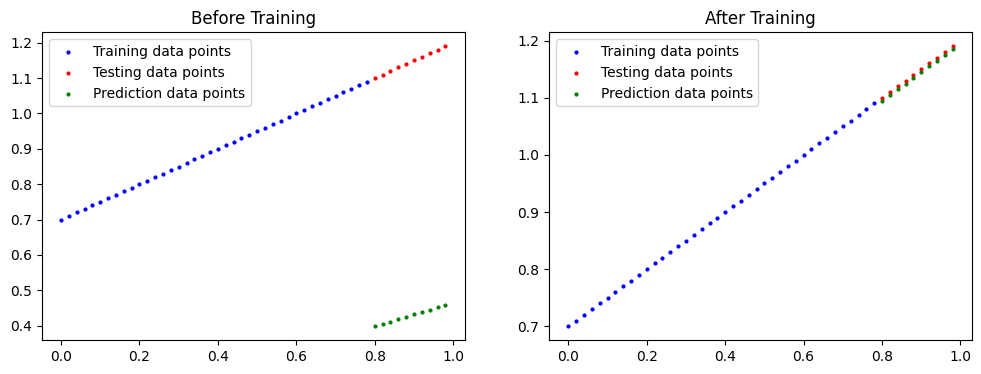

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

In [61]:
# Model predicting after the training is done
with torch.inference_mode():
  y_pred_after_training = model_0(X_test)

# Plotting to see the performance of the model
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 2, figsize=(12, 4))  # Specify figsize if needed

# Plot the first graph on the first subplot
plot_graph(axis=axis[0], prediction=y_prediction)
axis[0].set_title('Before Training')  # Add title if needed

# Plot the second graph on the second subplot
plot_graph(axis=axis[1], prediction=y_pred_after_training)
axis[1].set_title('After Training')  # Add title if needed

plt.show()

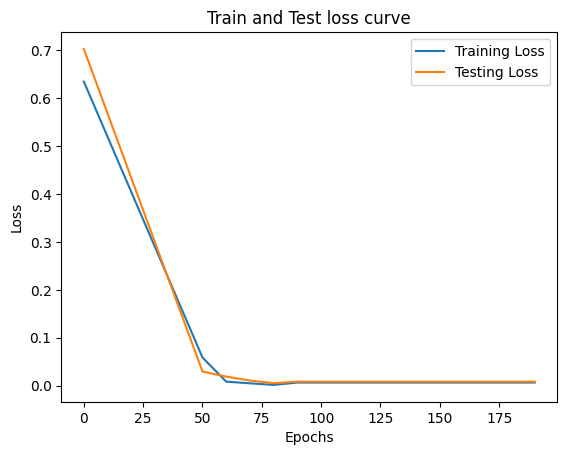

In [62]:
# Ploting the training and testing loss to see the performance of the model
plt.plot(epoch_value, torch.Tensor(training_loss).numpy(), label='Training Loss')
plt.plot(epoch_value, torch.Tensor(testing_loss).numpy(), label='Testing Loss')
plt.title("Train and Test loss curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Saving the model

In [63]:
from pathlib import Path

# Creating the folder to save the model
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Setting the name of the model
MODEL_NAME = '01_Linear_regression_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model to the models folder
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

##Loading the saved model

In [64]:
# To load the model we need to create the instance of the model before loading the model
load_model_0 = LinearRegressionModel()

# Once you created the instance we can now load the saved model to the new instance
load_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [65]:
# To test the model on testing data we need to first enter into evaluate mode
load_model_0.eval()

# We are using inference_mode so that code can better perform by disabling view tracking and version counter bumps
with torch.inference_mode():
  # Predicting values using the loaded model
  y_pred_after_loading_saved_model = load_model_0(X_test)

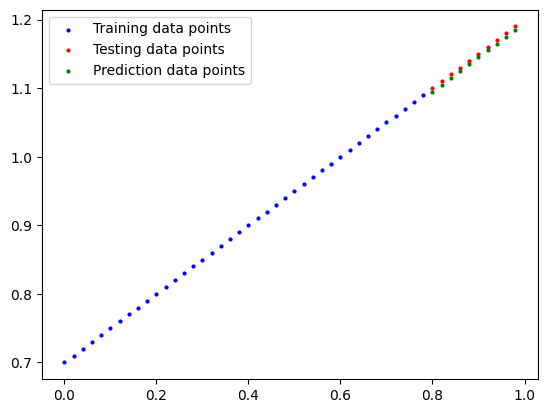

<Figure size 1000x700 with 0 Axes>

In [66]:
# Plotting to visualize
figure, axis = plt.subplots(1, 1)
plot_graph(axis, prediction=y_pred_after_loading_saved_model)